In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-train.csv')

In [ ]:
# train = pd.DataFrame()
# test = pd.DataFrame()
# for index in df.Index.unique():
#   df_index = df[df['Index']==index].sort_values('Date').reset_index(drop=True).copy()
#   splitter = int(len(df_index)*0.8)
#   train = train.append(df_index[:splitter].reset_index(drop=True))
#   test = test.append(df_index[splitter:].reset_index(drop=True))


In [ ]:
# train.to_csv('stock-market-train.csv',index=False)
# test.to_csv('stock-market-test.csv',index=False)

In [ ]:
df.isna().any()

Index        False
Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
CloseUSD     False
dtype: bool

In [ ]:
df.Index.value_counts()

NYA          11157
N225         11099
IXIC         10152
GSPTSE        8420
HSI           6793
GDAXI         6750
SSMI          6136
TWII          4695
000001.SS     4632
399001.SZ     4608
N100          4379
NSEI          2676
J203.JO       1876
Name: Index, dtype: int64

In [ ]:
df.groupby('Index').count()['Volume']

Index
000001.SS     4632
399001.SZ     4608
GDAXI         6750
GSPTSE        8420
HSI           6793
IXIC         10152
J203.JO       1876
N100          4379
N225         11099
NSEI          2676
NYA          11157
SSMI          6136
TWII          4695
Name: Volume, dtype: int64

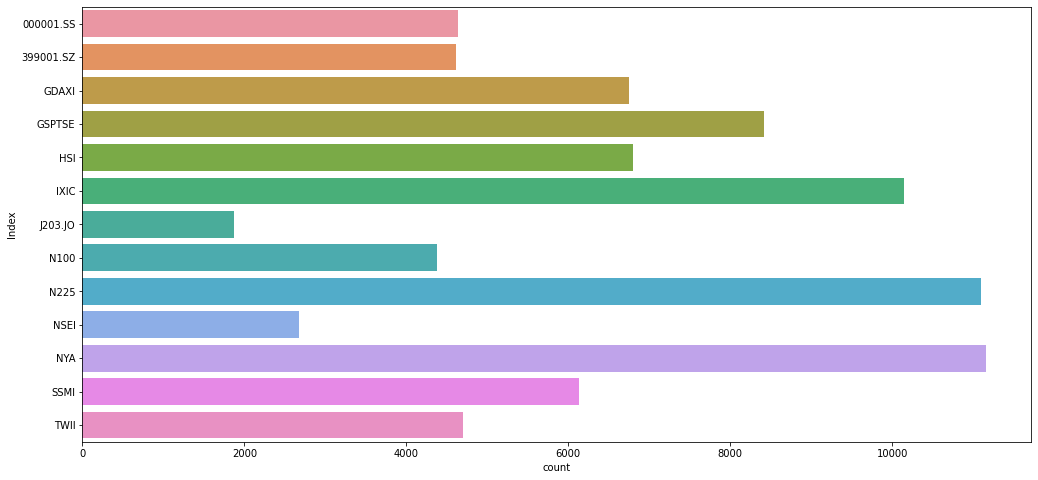

In [ ]:
df_bar = pd.DataFrame()
plt.figure(figsize=(17,8))
df_bar['count'] = df.groupby('Index').count()['Volume'].copy()
sns.barplot(y=df_bar.index,x='count',data=df_bar)
plt.show()

####Here we have a comparison of stock indexes records in our dataset, let's visualize those records

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

for i in df.Index.unique():
  df_Index = df[df['Index']==i].copy()

  fig = go.Figure(data=[go.Candlestick(x=df_Index['Date'],
                  open=df_Index['Open'],
                  high=df_Index['High'],
                  low=df_Index['Low'],
                  close=df_Index['Close'])])
  plt.figure(figsize=(22,10))
  # df_Index['Year'] = pd.to_datetime(df_Index['Date']).dt.year
  # sns.barplot(x=df_Index['Year'],y=df_Index.groupby('Year')['Volume'].sum())
  # fig.update_layout(xaxis_rangeslider_visible=False)
  # plt.xlabel(i)
  fig.update_layout(
    title=i
  )

  fig.show()
  plt.show()



<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

<Figure size 1584x720 with 0 Axes>

From this we found the repeating pattern in the market of each indexes and  also the market price drop in october 2008

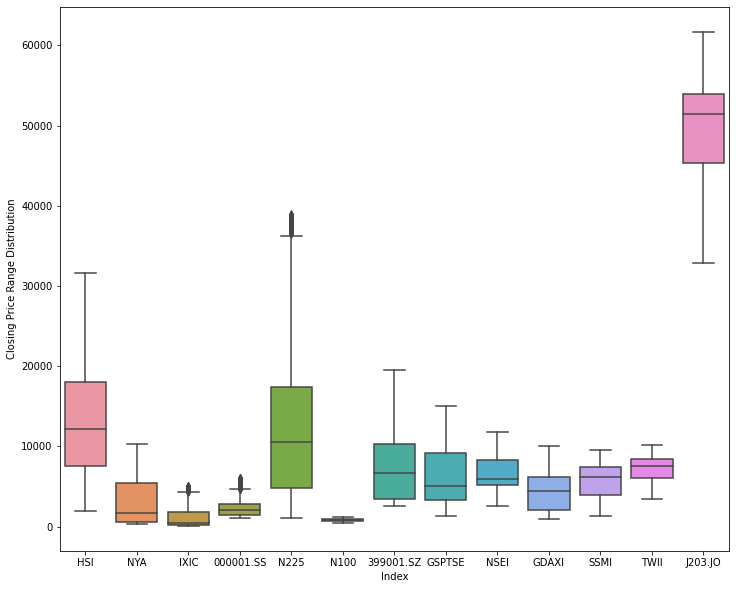

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(x="Index", y="Close", data=df)
plt.ylabel('Closing Price Range Distribution')
  # plt.xlabel(i)
plt.show()

J203.JO have a different close price distribution than the other index let's take a look at it's trading volume

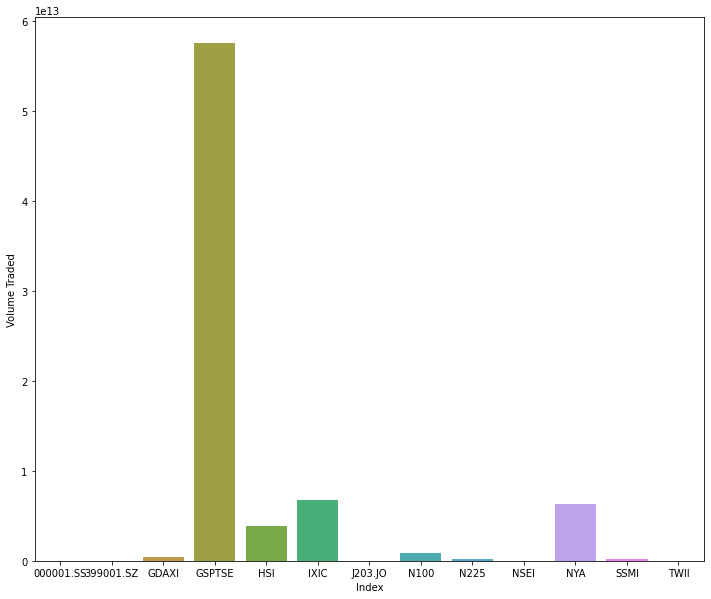

In [ ]:
plt.figure(figsize=(12,10))
df_bar['total_volume'] = df.groupby('Index').Volume.sum()
sns.barplot(y="total_volume", x=df_bar.index, data=df_bar)
plt.ylabel('Volume Traded')
  # plt.xlabel(i)
plt.show()

Here we have volume traded per stock. After further research it seems J203.JO is hold by Johannesburg Stock Exchange which is the largest exchange in the Africa continent so the price distribution make sense but not the absence of the volume.

In [ ]:
# sns.heatmap(df.corr(),annot=True)
# plt.show()

Now let's take a look at our data with the indicators, for this analysis will be using simple moving average with exponential moving average, moving average convergence divergence, relative strength index. The moving averages indicators we will also use as features for training to generalize the direction of the trend. We also want to convert the volume to on base volume to see the accumulative volume of the trades. Moving Averages will show the average price with a certain number of lookback period we will use 50 lookback days, MACD will show the relation of 2 exponential moving average, and RSI shows the momentum of the trend.

In [ ]:
def calc_SMA(closing,lookback=50):
  SMA = []
  MA = [closing[:lookback]]
  for price in closing[lookback:]:
    MA.pop(0)
    MA.append(price)
    SMA.append(sum(MA)/len(MA))
  return pd.Series(SMA,name='SMA').dropna()

def calc_EMA(closing,lookback=50,smoothing=2):
  EMA = [sum(closing[:lookback])/lookback]
  for price in closing[lookback:]:
    EMA.append((price * (smoothing / (1 + lookback))) + EMA[-1] * (1 - (smoothing / (1 + lookback))))
  return pd.Series(EMA,name='EMA').dropna()

def calc_MACD(EMA_12,EMA_26):
  MACD = []
  for first,second in zip(EMA_12,EMA_26):
    MACD.append(first-second)
  return pd.Series(MACD,name='MACD').dropna()

def calc_RSI(closing, lookback=50):
    ret = closing.diff()
    up = []
    down = []
    for diff in ret:
        if diff < 0:
            up.append(0)
            down.append(diff)
        else:
            up.append(diff)
            down.append(0)

    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    RS = up_ewm/down_ewm
    RSI = 100 - (100 / (1 + RS))
    return RSI.rename({0:'RSI'}).dropna()

def calc_OBV(closing,volume,lookback=50):
  OBV = [0]
  for i in range(lookback,len(closing)):
    OBV.append((OBV[len(OBV)-1]-volume[i-1])*(closing[i-1] < closing[i-2])+(OBV[len(OBV)-1]+volume[i-1])*(closing[i-1] > closing[i-2]))

  return pd.Series(OBV[1:],name='OBV').dropna()

def calc_target(closing,open,lookback=50):
  target = []
  for i in range(lookback,len(closing)):
    target.append(int(open[i] < closing[i]))
  return pd.Series(target,name='target').dropna()

In [ ]:
calc_RSI(df['Close'][:15])

1      0.000000
2     30.798976
3     61.658596
4     71.282972
5     68.412765
6     47.188164
7     62.407468
8     55.071350
9     51.821430
10    47.486820
11    44.225865
12    32.792387
13    31.712273
14    46.074820
dtype: float64

In [ ]:
df['Close'][:15]

0     2568.300049
1     2540.100098
2     2552.399902
3     2583.899902
4     2607.100098
5     2603.300049
6     2561.699951
7     2614.899902
8     2590.800049
9     2578.199951
10    2559.100098
11    2542.600098
12    2460.500000
13    2449.899902
14    2533.899902
Name: Close, dtype: float64

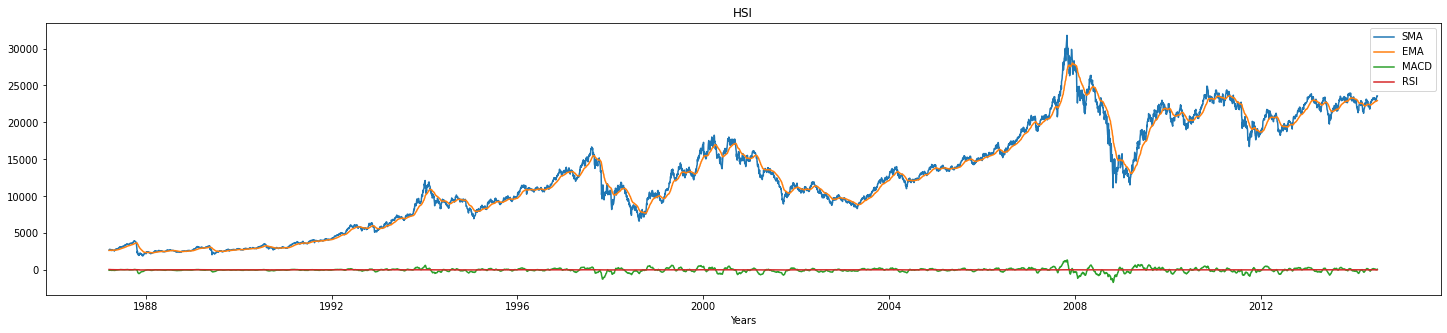

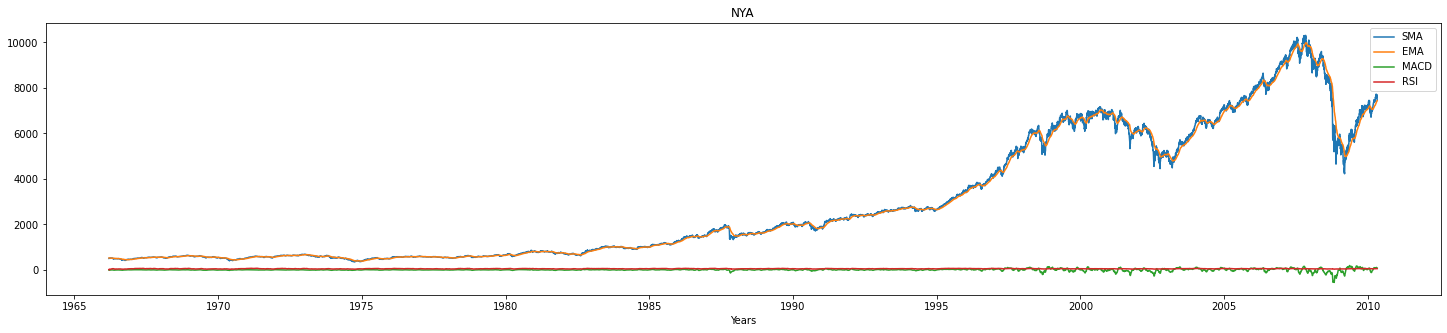

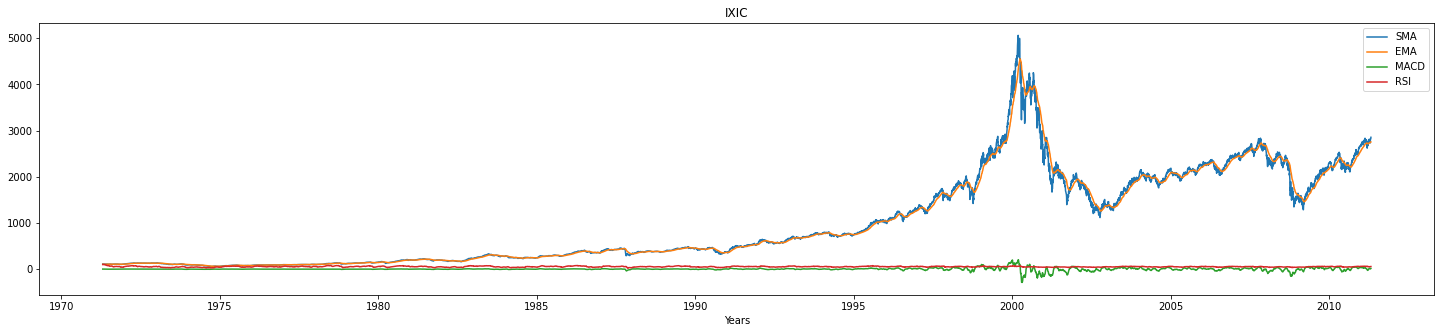

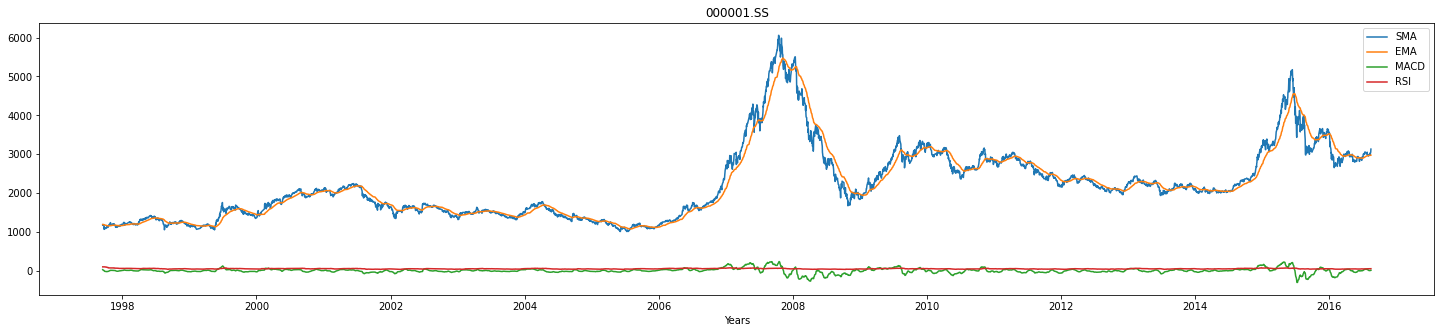

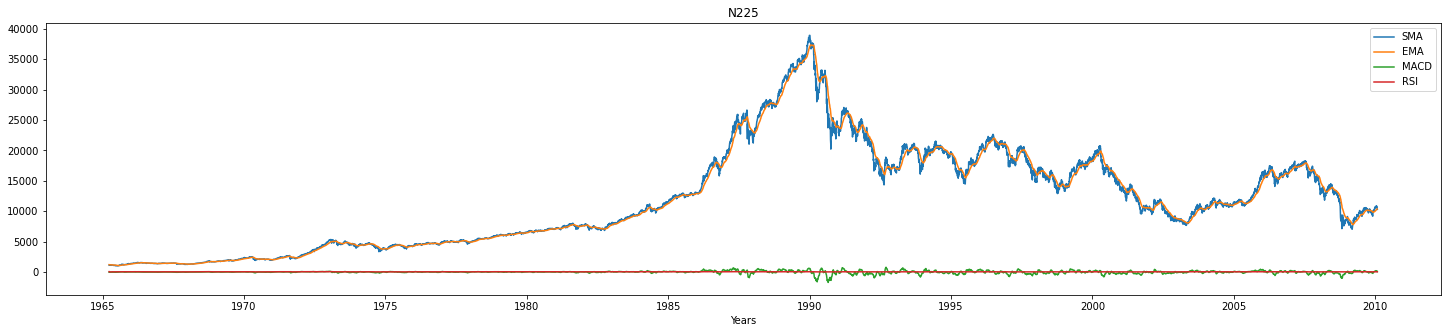

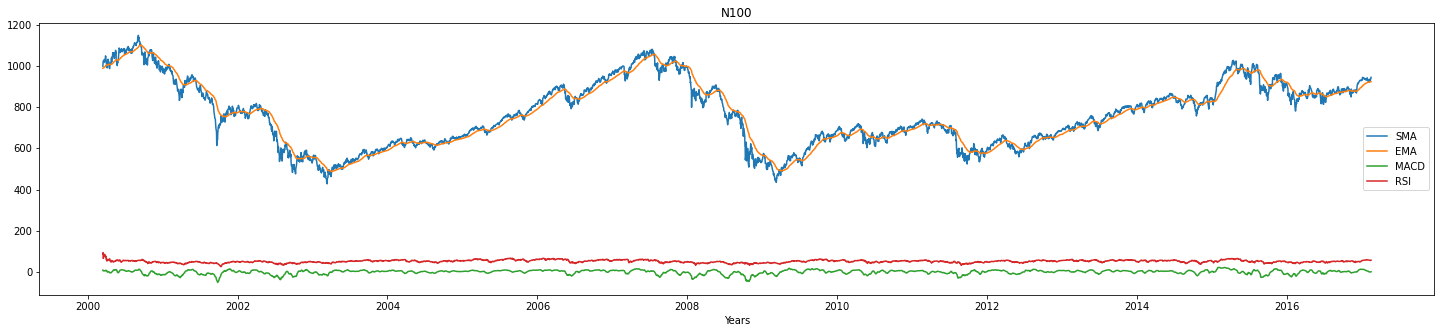

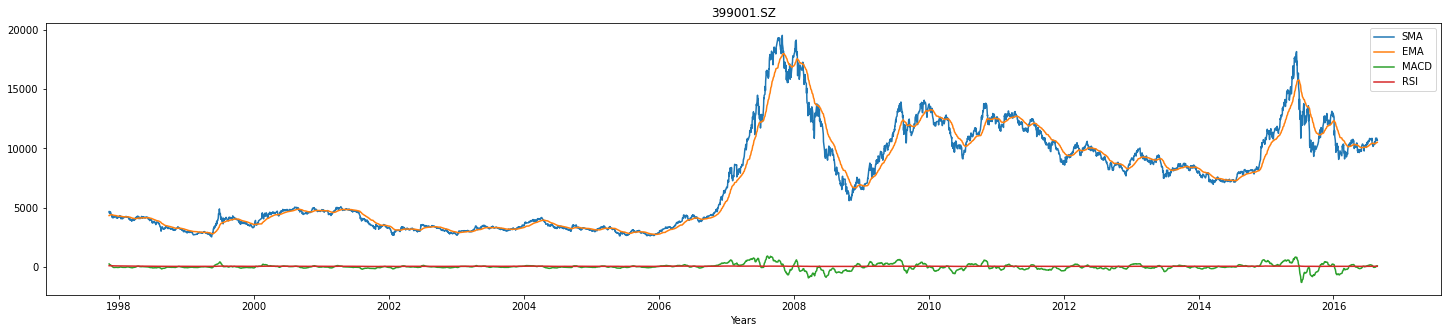

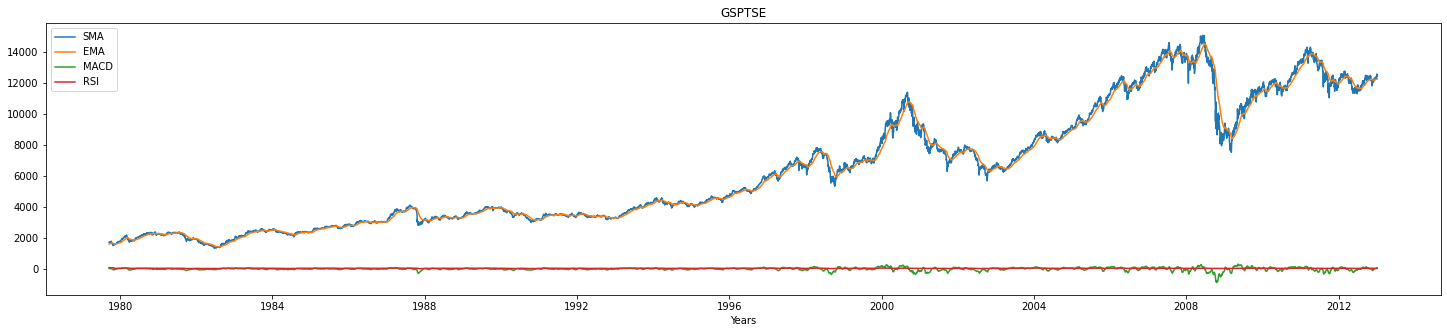

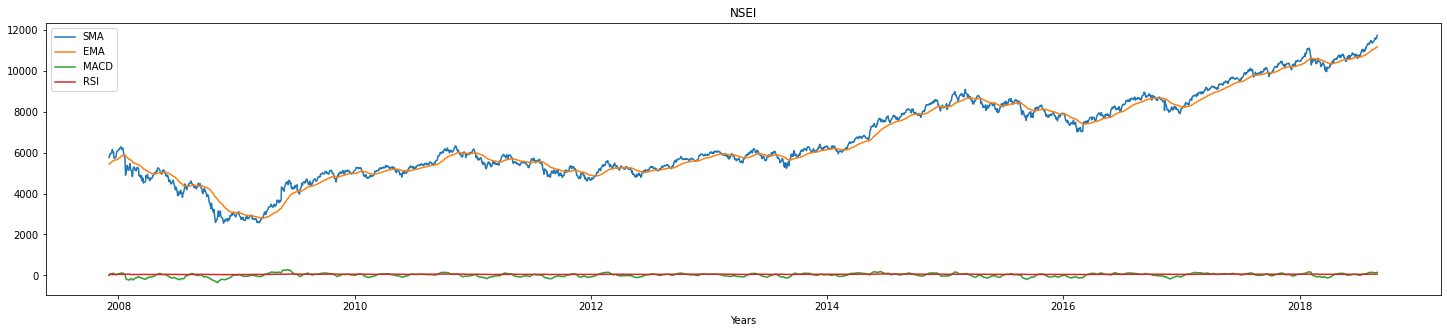

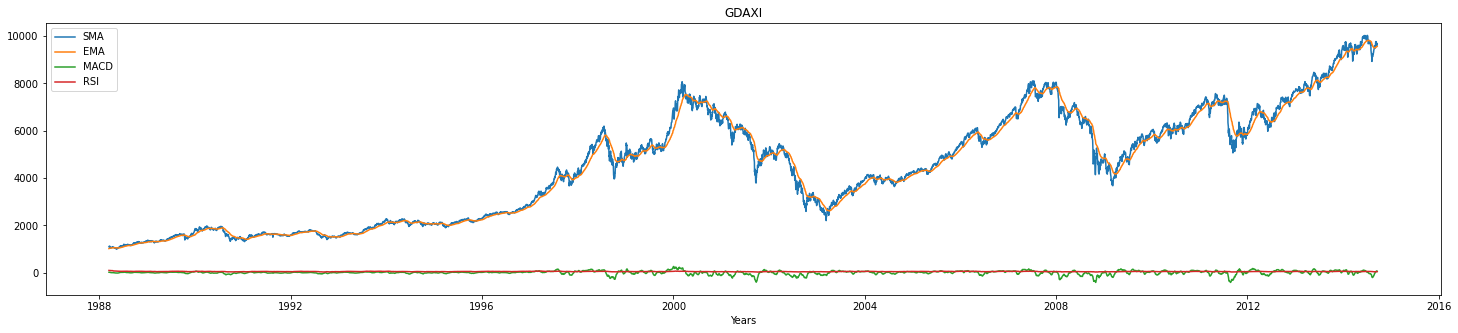

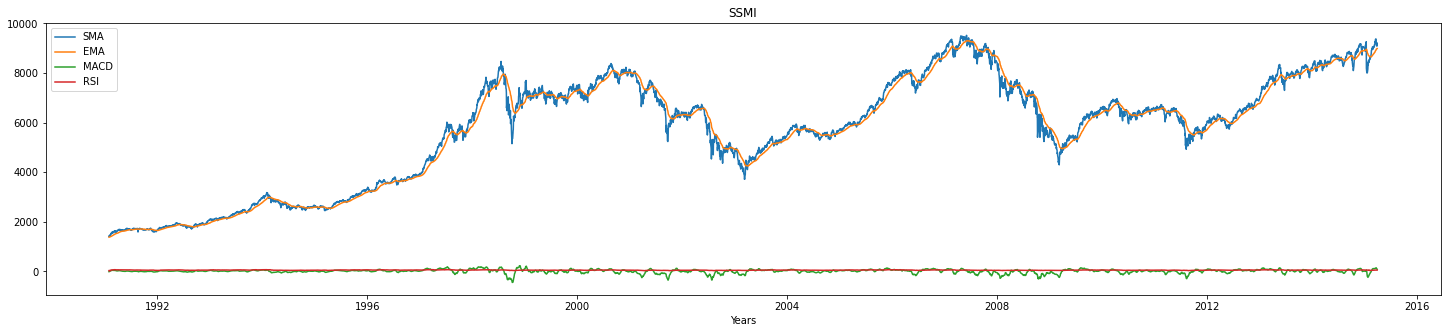

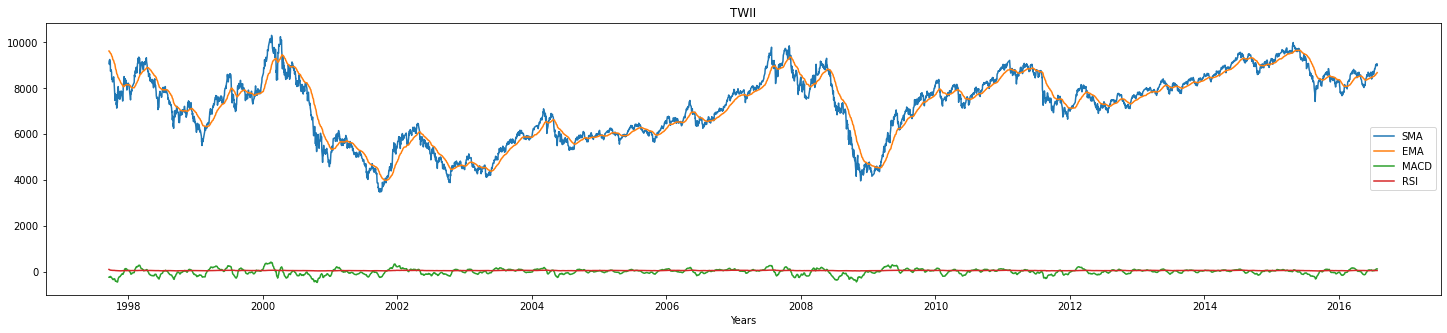

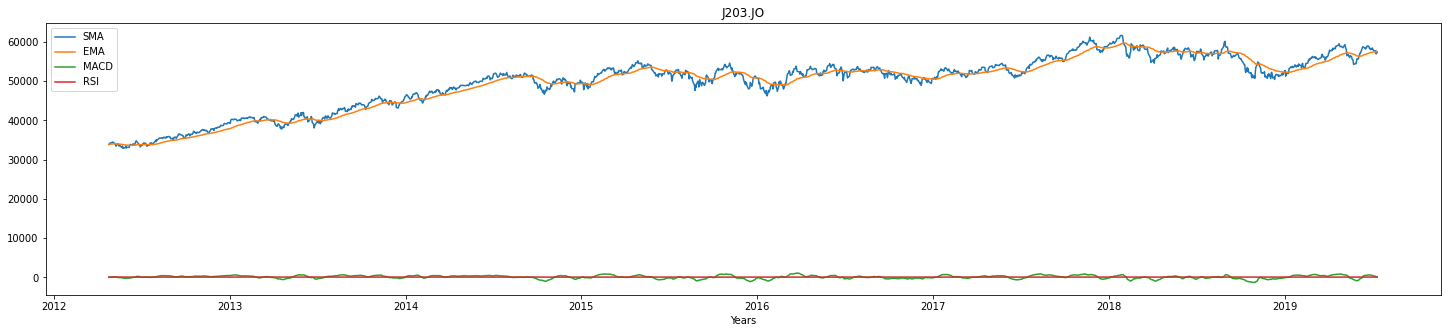

In [ ]:
new_df = pd.DataFrame()
for index in df.Index.unique():
  df_index = df[df['Index']==index].reset_index(drop=True).copy()
  closing = df_index['Open']
  days = 50
  Indicators = pd.DataFrame({
      'Date' : df_index['Date'][50:].reset_index(drop=True),
      'SMA' : calc_SMA(closing,days),
      'EMA' : calc_EMA(closing,lookback = days),
      'MACD' : calc_MACD(calc_EMA(closing[38:],lookback=12),calc_EMA(closing[24:],lookback=26)),
      'RSI' : calc_RSI(closing[36:]),
      'OBV' : calc_OBV(closing = closing,volume = df_index['Volume']),
      'Target' : calc_target(df_index['Close'],closing,days)
      })
  
  df_index = pd.merge(df_index[53:-1].reset_index(drop=True),Indicators[3:-1].reset_index(drop=True),on='Date')
  # print(df_index)
  plt.figure(figsize=(25,5))
  
  plt.plot(pd.to_datetime(df_index['Date']).dt.date,df_index[['SMA','EMA','MACD','RSI','Date']].set_index('Date'))
  # sns.lineplot(data=pd.Series(calc_EMA(closing[41:],lookback = 9),name='MACD Baseline'))
  # sns.barplot(data=df_index['Target'])
  plt.xlabel('Years')
  plt.title(index)
  plt.legend(['SMA','EMA','MACD','RSI'])
  plt.show()
  # df_index = df_index[20:].reset_index(drop=True)
  new_df = new_df.append(df_index).reset_index(drop=True)

The reason we use simple moving average paired with EMA exponential moving average is to generalize the trend direction where EMA put a high emphasize on the current price direction we paired it with SMA to balance it out. We also use MACD and RSI to see the direction's momentum where the MACD measures the relationship between two EMAs (12-period and 26-period), while the RSI measures price change in relation to recent price highs and lows. This will also help our model to look for patterns in the market trend direction.

In [ ]:
new_df[:18]

Index        Date         Open  ...        RSI  OBV  Target
0    HSI  1987-03-19  2721.300049  ...  97.709236  0.0     0.0
1    HSI  1987-03-20  2780.600098  ...  97.738722  0.0     0.0
2    HSI  1987-03-23  2813.399902  ...  97.817043  0.0     0.0
3    HSI  1987-03-24  2828.100098  ...  94.233809  0.0     0.0
4    HSI  1987-03-25  2831.500000  ...  87.926457  0.0     0.0
5    HSI  1987-03-26  2783.100098  ...  87.928241  0.0     0.0
6    HSI  1987-03-27  2798.699951  ...  88.123284  0.0     0.0
7    HSI  1987-03-30  2774.899902  ...  82.548336  0.0     0.0
8    HSI  1987-03-31  2713.800049  ...  82.916353  0.0     0.0
9    HSI  1987-04-01  2695.899902  ...  82.274740  0.0     0.0
10   HSI  1987-04-02  2709.399902  ...  80.572278  0.0     0.0
11   HSI  1987-04-03  2680.000000  ...  77.645114  0.0     0.0
12   HSI  1987-04-07  2664.699951  ...  75.460317  0.0     0.0
13   HSI  1987-04-08  2729.600098  ...  77.011375  0.0     0.0
14   HSI  1987-04-09  2785.500000  ...  76.870025  0.0     0.0
15   HSI  1987-04-10  2766.399902  ...  77.783891  0.0     0.0
16   HSI  1987-04-13  2708.899902  ...  78.268495  0.0     0.0
17   HSI  1987-04-14  2668.399902  ...  78.483141  0.0     0.0

[18 rows x 15 columns]

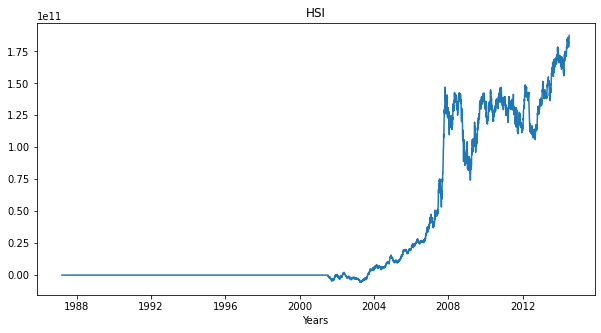

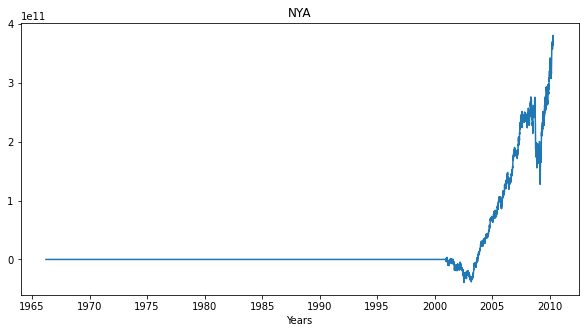

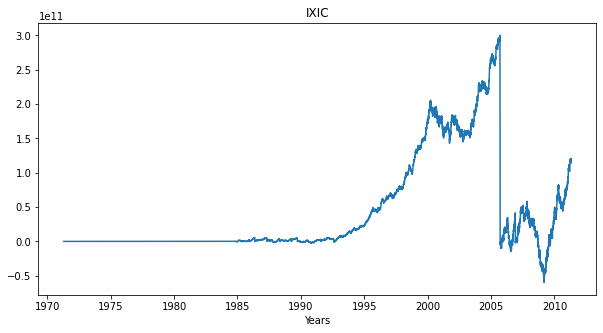

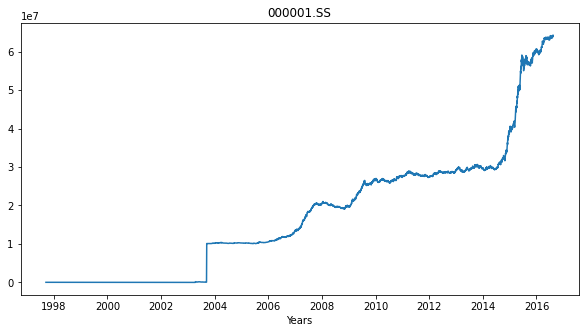

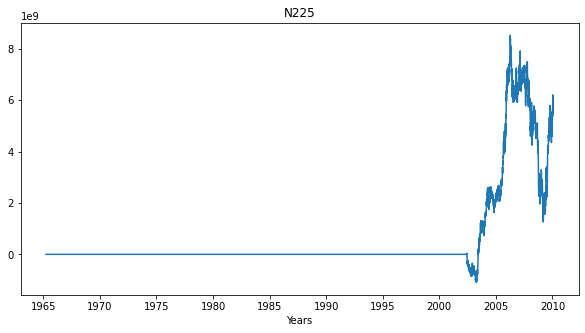

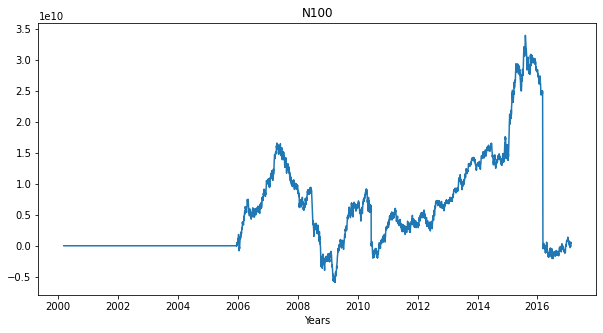

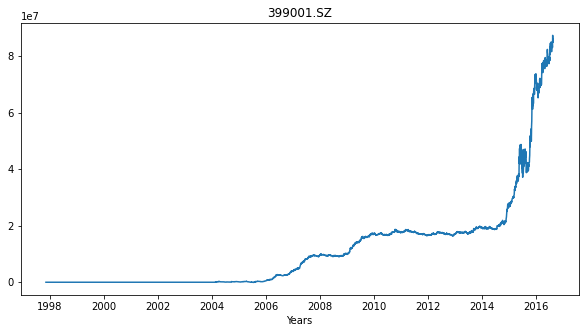

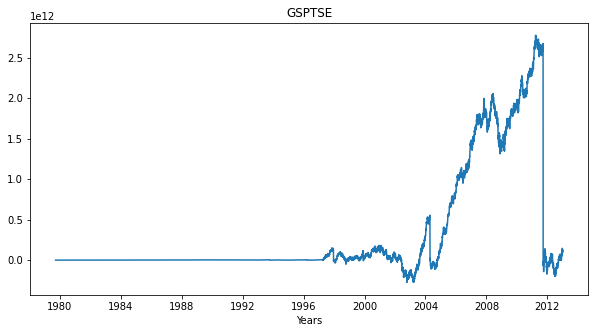

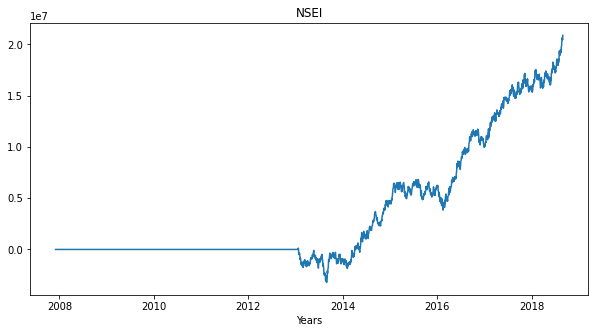

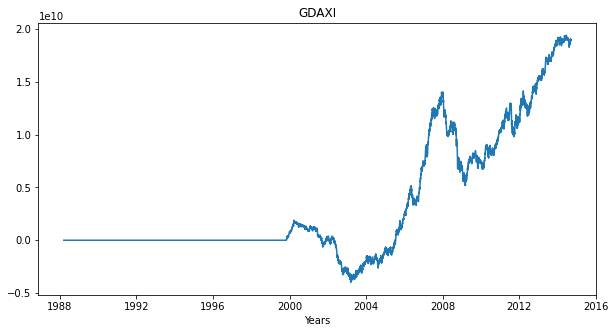

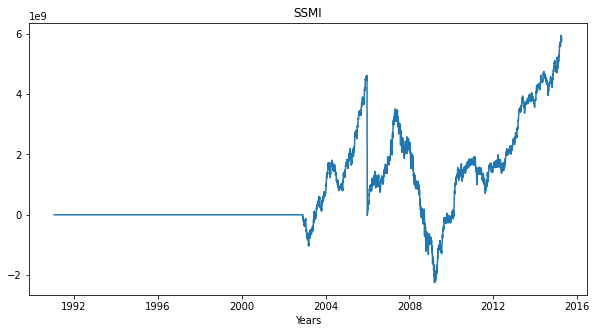

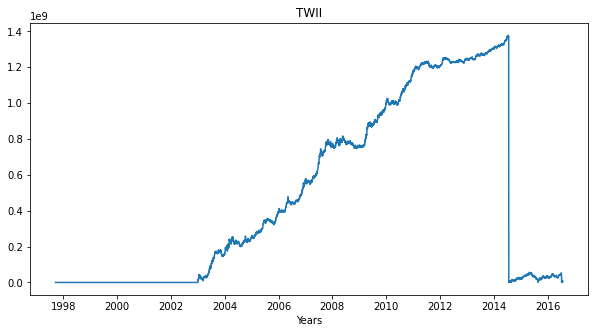

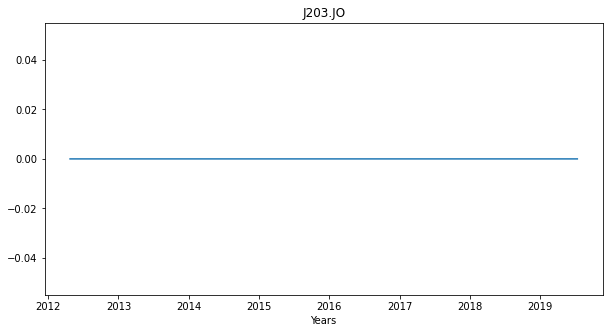

In [ ]:
for index in new_df.Index.unique():
  df_index = new_df[new_df['Index']==index].reset_index(drop=True).copy()
  
  # print(df_index)
  plt.figure(figsize=(10,5))
  
  plt.plot(pd.to_datetime(df_index['Date']).dt.date,df_index[['OBV','Date']].set_index('Date'))
  # plt.show()
  # sns.lineplot(data=pd.Series(calc_EMA(closing[41:],lookback = 9),name='MACD Baseline'))
  # sns.barplot(data=df_index['Target'])
  plt.xlabel('Years')
  plt.title(index)
  # plt.show()


OBV shows how big the trend direction took based on it's exchanged volume, this shows the crowd sentiment which can indicate a bullish or a bearish outcome. it's look like our data has a bigger rising trend 

In [ ]:
df_bar

count  total_volume
Index                         
000001.SS   4632  3.683779e+08
399001.SZ   4608  6.677568e+08
GDAXI       6750  4.189335e+11
GSPTSE      8420  5.759071e+13
HSI         6793  3.912545e+12
IXIC       10152  6.749028e+12
J203.JO     1876  0.000000e+00
N100        4379  8.635974e+11
N225       11099  2.080289e+11
NSEI        2676  2.507195e+08
NYA        11157  6.299719e+12
SSMI        6136  1.898946e+11
TWII        4695  1.104981e+10

Now let's check our target distribution count

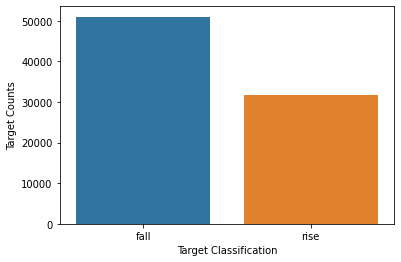

In [ ]:
df_bar = new_df.copy()
df_bar['Target'] = [(x==0)*'fall' + (x==1)*'rise' for x in df_bar['Target']]

to_plot = df_bar.groupby('Target')['Index'].count()
sns.barplot(y=to_plot,x=to_plot.index)
plt.xlabel('Target Classification')
plt.ylabel('Target Counts')
plt.show()
  

From these analysis our features bear a correlation with our target as an indicators which is a more generalized version of our features. By using indicators we can pick up target pattern hence help predicting the direction of the trend(our target). OBV indicator also shows a correlation in volume of our target. it looks like our data is imbalance we will get back to that later.

In [ ]:
new_df.Date

0        1987-03-19
1        1987-03-20
2        1987-03-23
3        1987-03-24
4        1987-03-25
            ...    
82666    2019-07-08
82667    2019-07-09
82668    2019-07-10
82669    2019-07-11
82670    2019-07-12
Name: Date, Length: 82671, dtype: object

Next, we will take a look at the mutual information of our features

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = new_df.drop(['Date'],axis=1).copy()
y = X.pop("Target")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

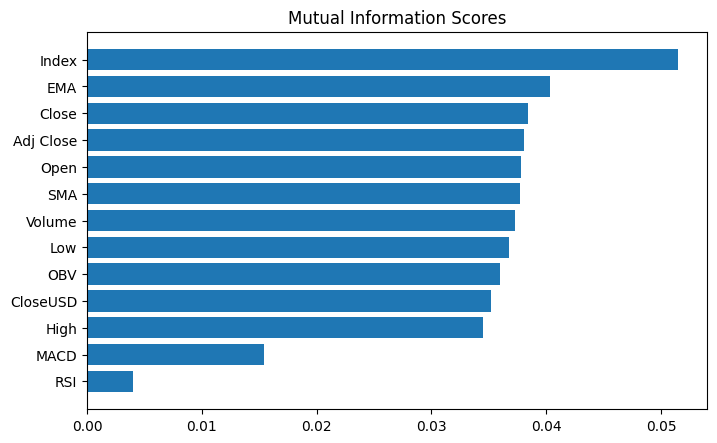

In [ ]:
import numpy as np


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

These features will be considered later in feature selection

In [ ]:
# categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
#numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

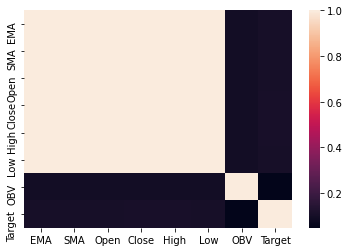

In [ ]:
sns.heatmap(new_df[['EMA','SMA','Open','Close','High','Low','OBV','Target']].corr())

Because SMA was taken linearly from the opening price we can drop the Open price column following the High Low column which both have high linear correlation with SMA. Close price column will also be drop since we have turn it to Target column where if the closing price is greater than the opening out target is a 1 and 0 vice versa